In [36]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


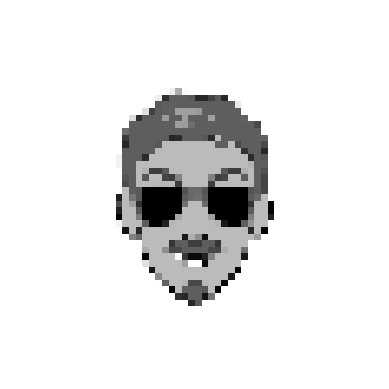

In [37]:
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import generacion_cartoon.utils.paths as path
import notebooks.drac_CVAE_modified as CVAE
import generacion_cartoon.visualization.visualize as visualize 
import tensorflow as tf
import time
import numpy as np

In [38]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


In [39]:
import mlflow
import dagshub

In [40]:
params ={'latent_dim':2,
 'epochs':150,
 'gamma':0.00075,
 'beta':1.0,
 'epsilon':1e-6}

model = CVAE.CVAE(latent_dim=params['latent_dim'],
  gamma=params['gamma'],
  beta=params['beta'])

In [41]:
name_model = f'model_modified_gamma={params["gamma"]}_beta={params["beta"]}_epochs={params["epochs"]}.weights.h5'
path_models = path.models_dir(name_model)

In [ ]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
mlflow.set_experiment("LossFuntion_Modified_gamma_beta")
mlflow.start_run()
mlflow.log_params(params)

tf.config.run_functions_eagerly(True)
visualize.plot_latent_images(model=model, num_images_x=20, epoch=0)

optimizer = tf.keras.optimizers.Adam(params['epsilon'])
best_elbo = -100000
count = 0
patience = 10
for epoch in range(1, params['epochs'] + 1):
    start_time = time.time()

    for idx, train_x in enumerate(train_ds):
        CVAE.train_step(model, train_x, optimizer)

        if epoch == 1 and idx % 75 == 0:
            visualize.plot_latent_images(model=model,
            num_images_x=20,
            epoch=epoch,
            first_epoch=True,
            f_ep_count=idx)      

    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(CVAE.compute_loss(model, test_x))
    elbo = -loss.result()
    if elbo > best_elbo:
        best_elbo = elbo
        model.save_weights(path_models)
        print('Best model saved with best ELBO: {:.2f}'.format(elbo))
        count=0
    else:
        count = count + 1
    mlflow.log_metric('elbo_loss_test', elbo, step = epoch)
    print('Epoch: {}, Test set ELBO: {:.2f}, time elapse for current epoch: {:.2f}'
        .format(epoch, elbo, end_time - start_time))
    if epoch != 1:
        visualize.plot_latent_images(model=model, num_images_x= 20, epoch=epoch)
    if count == patience:
        break
#mlflow.tensorflow.log_model(model, 'model')        
mlflow.end_run()

In [43]:

#mlflow.end_run()

In [44]:
name_gif = f'grid_modified_gamma={params["gamma"]}_beta={params["beta"]}_epoch={params["epochs"]}.gif'
visualize.create_gif(name_gif=name_gif)


In [45]:
model.load_weights(path_models)

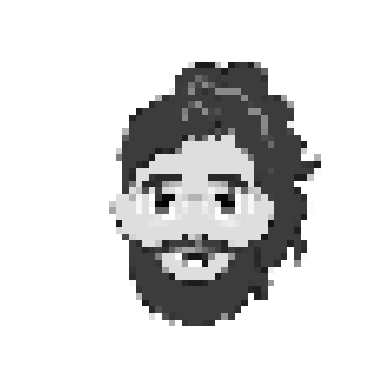

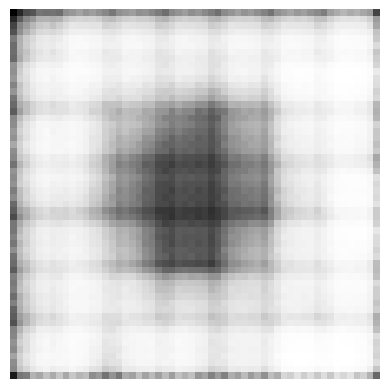

In [46]:
visualize.plot_img_original_generated(model=model,num_img=10,test_ds=test_ds)